In [1]:
import numpy as np
import scipy
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
import astropy.constants as const
from scipy.spatial.transform import Rotation as R
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator
plt.style.use('science')
rcParams['axes.linewidth'] = 2
from copy import deepcopy
import datetime
import ChiantiPy.core as ch
import astropy.time


 ChiantiPy version 0.11.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [2]:
k_B = const.k_B.cgs.value
m_p = const.m_p.cgs.value

In [3]:
sat_df = pd.read_csv("../src/sim/2005CME_Earth_data.dat",skiprows=1,sep="\s+")
cols=["year","mo","dy","hr","mn","sc","msc"]
sat_df['dateobs'] = sat_df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")
sat_df["dateobs"] = pd.to_datetime(sat_df["dateobs"],format="%Y/%m/%d/%H/%M/%S/%f")
sat_df = sat_df.set_index("dateobs")
sat_df["n"] = sat_df["rho"]/m_p
sat_df["ti"] = sat_df["p"]/sat_df["n"]/k_B
sat_df["te"] = sat_df["pe"]/sat_df["n"]/k_B
sat_df["ut"] = np.sqrt(sat_df["ux"]**2 + sat_df["uy"]**2 + sat_df["uz"]**2)
sat_df["bt"] = np.sqrt(sat_df["bx"]**2 + sat_df["by"]**2 + sat_df["bz"]**2)
sat_df["ur"] = (sat_df["ux"]*sat_df["X"] + sat_df["uy"]*sat_df["Y"] + sat_df["uz"]*sat_df["Z"])/ \
                np.sqrt(sat_df["X"]**2 + sat_df["Y"]**2 + sat_df["Z"]**2)
sat_df

,it,year,mo,dy,hr,mn,sc,msc,X,Y,...,by,bz,p,pe,n,ti,te,ut,bt,ur
dateobs,,,,,,,,,,,,,,,,,,,,,
2005-05-14 08:10:00.000,108869,2005,5,14,8,10,0,0,-201.24,81.18,...,0.000015,-0.000002,4.365890e-11,4.365830e-11,14.466150,21859.314384,21859.013974,389.105268,0.000016,389.055166
2005-05-14 08:15:00.380,109224,2005,5,14,8,15,0,380,-201.25,81.16,...,0.000015,-0.000002,4.364520e-11,4.364440e-11,14.467585,21850.287720,21849.887212,388.976402,0.000016,388.926227
2005-05-14 08:20:00.000,109599,2005,5,14,8,20,0,0,-201.25,81.15,...,0.000015,-0.000002,4.363950e-11,4.363870e-11,14.471890,21840.935652,21840.535263,388.816144,0.000016,388.765895
2005-05-14 08:25:00.710,110082,2005,5,14,8,25,0,71,-201.26,81.14,...,0.000015,-0.000002,4.362190e-11,4.362110e-11,14.472787,21830.774296,21830.373932,388.680206,0.000016,388.629874
2005-05-14 08:30:00.000,110534,2005,5,14,8,30,0,0,-201.26,81.13,...,0.000015,-0.000002,4.361040e-11,4.360960e-11,14.475477,21820.962710,21820.562420,388.526823,0.000016,388.476399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-22 11:20:00.000,1061234,2005,5,22,11,20,0,0,-210.86,53.30,...,0.000039,-0.000079,1.668160e-11,1.656520e-11,3.237444,37320.902770,37060.486917,532.373790,0.000121,531.782965
2005-05-22 11:25:00.880,1061583,2005,5,22,11,25,0,88,-210.87,53.29,...,0.000039,-0.000079,1.668900e-11,1.657240e-11,3.237659,37334.976322,37074.130361,532.381196,0.000121,531.791751
2005-05-22 11:30:00.000,1061939,2005,5,22,11,30,0,0,-210.87,53.28,...,0.000039,-0.000079,1.669980e-11,1.658300e-11,3.238221,37352.653349,37091.405316,532.389352,0.000121,531.801438


In [4]:
sat_df_gse = deepcopy(sat_df)

for index, row in sat_df_gse.iterrows():
    x_sat = row["X"]
    y_sat = row["Y"]
    z_sat = row["Z"]
    phi_sat = np.arctan2(y_sat,x_sat)
    theta_sat = np.arccos(z_sat/np.sqrt(x_sat**2 + y_sat**2 + z_sat**2))
    r_matrix = R.from_euler("zy",[phi_sat - np.pi,theta_sat-np.pi/2])
    r_matrix = r_matrix.inv()
    u_vec = np.array([row["ux"],row["uy"],row["uz"]])
    b_vec = np.array([row["bx"],row["by"],row["bz"]])
    sat_df_gse.at[index,"ux"],sat_df_gse.at[index,"uy"],sat_df_gse.at[index,"uz"] = r_matrix.apply(u_vec)
    sat_df_gse.at[index,"bx"],sat_df_gse.at[index,"by"],sat_df_gse.at[index,"bz"] = r_matrix.apply(b_vec)

sat_df_gse


,it,year,mo,dy,hr,mn,sc,msc,X,Y,...,by,bz,p,pe,n,ti,te,ut,bt,ur
dateobs,,,,,,,,,,,,,,,,,,,,,
2005-05-14 08:10:00.000,108869,2005,5,14,8,10,0,0,-201.24,81.18,...,0.000012,-0.000002,4.365890e-11,4.365830e-11,14.466150,21859.314384,21859.013974,389.105268,0.000016,389.055166
2005-05-14 08:15:00.380,109224,2005,5,14,8,15,0,380,-201.25,81.16,...,0.000012,-0.000002,4.364520e-11,4.364440e-11,14.467585,21850.287720,21849.887212,388.976402,0.000016,388.926227
2005-05-14 08:20:00.000,109599,2005,5,14,8,20,0,0,-201.25,81.15,...,0.000012,-0.000002,4.363950e-11,4.363870e-11,14.471890,21840.935652,21840.535263,388.816144,0.000016,388.765895
2005-05-14 08:25:00.710,110082,2005,5,14,8,25,0,71,-201.26,81.14,...,0.000012,-0.000002,4.362190e-11,4.362110e-11,14.472787,21830.774296,21830.373932,388.680206,0.000016,388.629874
2005-05-14 08:30:00.000,110534,2005,5,14,8,30,0,0,-201.26,81.13,...,0.000012,-0.000002,4.361040e-11,4.360960e-11,14.475477,21820.962710,21820.562420,388.526823,0.000016,388.476399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-22 11:20:00.000,1061234,2005,5,22,11,20,0,0,-210.86,53.30,...,0.000018,-0.000081,1.668160e-11,1.656520e-11,3.237444,37320.902770,37060.486917,532.373790,0.000121,531.782965
2005-05-22 11:25:00.880,1061583,2005,5,22,11,25,0,88,-210.87,53.29,...,0.000018,-0.000081,1.668900e-11,1.657240e-11,3.237659,37334.976322,37074.130361,532.381196,0.000121,531.791751
2005-05-22 11:30:00.000,1061939,2005,5,22,11,30,0,0,-210.87,53.28,...,0.000018,-0.000081,1.669980e-11,1.658300e-11,3.238221,37352.653349,37091.405316,532.389352,0.000121,531.801438


In [5]:
sat_vel_df = pd.read_excel("../src/sim/Earth_Velocity.xlsx")
sat_vel_df = sat_vel_df.set_index("dateobs")
func_vx_e = interpolate.interp1d(astropy.time.Time(sat_vel_df.index).jd,sat_vel_df["vx_e"].values)
func_vy_e = interpolate.interp1d(astropy.time.Time(sat_vel_df.index).jd,sat_vel_df["vy_e"].values)
func_vz_e = interpolate.interp1d(astropy.time.Time(sat_vel_df.index).jd,sat_vel_df["vz_e"].values)

In [6]:
sat_df_gse_new = deepcopy(sat_df)

for index, row in sat_df_gse_new.iterrows():
    x_sat = row["X"]
    y_sat = row["Y"]
    z_sat = row["Z"]

    xprime_gse = np.array([-x_sat, -y_sat, -z_sat])
    xprime_gse = xprime_gse/np.linalg.norm(xprime_gse)
    zprime_gse = np.cross(np.array([1,0,0]),np.array([x_sat,y_sat,z_sat]))
    zprime_gse = zprime_gse/np.linalg.norm(zprime_gse)
    if zprime_gse[2] < 0:
        zprime_gse = -zprime_gse

    yprime_gse = np.cross(zprime_gse, xprime_gse)
    rot_matrix = np.row_stack((xprime_gse,yprime_gse,zprime_gse))
    rotation = R.from_matrix(rot_matrix)

    dateobs_jd = astropy.time.Time(index).jd
    u_earth = np.array([func_vx_e(dateobs_jd),func_vy_e(dateobs_jd),func_vz_e(dateobs_jd)])
    u_vec = np.array([row["ux"],row["uy"],row["uz"]]) - u_earth
    b_vec = np.array([row["bx"],row["by"],row["bz"]])
    
    sat_df_gse_new.at[index,"ux"],sat_df_gse_new.at[index,"uy"],sat_df_gse_new.at[index,"uz"] = rotation.apply(u_vec)
    sat_df_gse_new.at[index,"bx"],sat_df_gse_new.at[index,"by"],sat_df_gse_new.at[index,"bz"] = rotation.apply(b_vec)


sat_df_gse_new
    

,it,year,mo,dy,hr,mn,sc,msc,X,Y,...,by,bz,p,pe,n,ti,te,ut,bt,ur
dateobs,,,,,,,,,,,,,,,,,,,,,
2005-05-14 08:10:00.000,108869,2005,5,14,8,10,0,0,-201.24,81.18,...,0.000012,-2.881641e-07,4.365890e-11,4.365830e-11,14.466150,21859.314384,21859.013974,389.105268,0.000016,389.055166
2005-05-14 08:15:00.380,109224,2005,5,14,8,15,0,380,-201.25,81.16,...,0.000012,-2.762573e-07,4.364520e-11,4.364440e-11,14.467585,21850.287720,21849.887212,388.976402,0.000016,388.926227
2005-05-14 08:20:00.000,109599,2005,5,14,8,20,0,0,-201.25,81.15,...,0.000012,-2.640546e-07,4.363950e-11,4.363870e-11,14.471890,21840.935652,21840.535263,388.816144,0.000016,388.765895
2005-05-14 08:25:00.710,110082,2005,5,14,8,25,0,71,-201.26,81.14,...,0.000012,-2.517560e-07,4.362190e-11,4.362110e-11,14.472787,21830.774296,21830.373932,388.680206,0.000016,388.629874
2005-05-14 08:30:00.000,110534,2005,5,14,8,30,0,0,-201.26,81.13,...,0.000012,-2.378619e-07,4.361040e-11,4.360960e-11,14.475477,21820.962710,21820.562420,388.526823,0.000016,388.476399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-22 11:20:00.000,1061234,2005,5,22,11,20,0,0,-210.86,53.30,...,0.000027,-7.316353e-05,1.668160e-11,1.656520e-11,3.237444,37320.902770,37060.486917,532.373790,0.000121,531.782965
2005-05-22 11:25:00.880,1061583,2005,5,22,11,25,0,88,-210.87,53.29,...,0.000027,-7.323087e-05,1.668900e-11,1.657240e-11,3.237659,37334.976322,37074.130361,532.381196,0.000121,531.791751
2005-05-22 11:30:00.000,1061939,2005,5,22,11,30,0,0,-210.87,53.28,...,0.000027,-7.330772e-05,1.669980e-11,1.658300e-11,3.238221,37352.653349,37091.405316,532.389352,0.000121,531.801438


In [7]:
sat_df.loc[:,("X","Y","Z","ux","uy","uz","bx","by","bz")]


,X,Y,Z,ux,uy,uz,bx,by,bz
dateobs,,,,,,,,,
2005-05-14 08:10:00.000,-201.24,81.18,-10.33000,-361.232,144.081,-12.45060,-0.000005,0.000015,-0.000002
2005-05-14 08:15:00.380,-201.25,81.16,-10.33000,-361.136,143.974,-12.44660,-0.000005,0.000015,-0.000002
2005-05-14 08:20:00.000,-201.25,81.15,-10.32000,-361.004,143.874,-12.42490,-0.000005,0.000015,-0.000002
2005-05-14 08:25:00.710,-201.26,81.14,-10.32000,-360.896,143.778,-12.42040,-0.000005,0.000015,-0.000002
2005-05-14 08:30:00.000,-201.26,81.13,-10.32000,-360.770,143.680,-12.41600,-0.000005,0.000015,-0.000002
...,...,...,...,...,...,...,...,...,...
2005-05-22 11:20:00.000,-210.86,53.30,-6.78000,-519.489,116.353,3.87430,-0.000083,0.000039,-0.000079
2005-05-22 11:25:00.880,-210.87,53.29,-6.78000,-519.499,116.343,3.85138,-0.000083,0.000039,-0.000079
2005-05-22 11:30:00.000,-210.87,53.28,-6.78000,-519.508,116.341,3.82513,-0.000083,0.000039,-0.000079


In [8]:
sat_df_gse_new.loc[:,("X","Y","Z","ux","uy","uz","bx","by","bz")]

,X,Y,Z,ux,uy,uz,bx,by,bz
dateobs,,,,,,,,,
2005-05-14 08:10:00.000,-201.24,81.18,-10.33000,-388.651238,27.248349,5.836028,-0.000010,0.000012,-2.881641e-07
2005-05-14 08:15:00.380,-201.25,81.16,-10.33000,-388.521041,27.225147,5.831782,-0.000010,0.000012,-2.762573e-07
2005-05-14 08:20:00.000,-201.25,81.15,-10.32000,-388.361047,27.199504,5.822538,-0.000010,0.000012,-2.640546e-07
2005-05-14 08:25:00.710,-201.26,81.14,-10.32000,-388.225017,27.174481,5.817533,-0.000010,0.000012,-2.517560e-07
2005-05-14 08:30:00.000,-201.26,81.13,-10.32000,-388.072035,27.147666,5.812174,-0.000010,0.000012,-2.378619e-07
...,...,...,...,...,...,...,...,...,...
2005-05-22 11:20:00.000,-210.86,53.30,-6.78000,-531.418026,12.504491,18.523249,-0.000092,0.000027,-7.316353e-05
2005-05-22 11:25:00.880,-210.87,53.29,-6.78000,-531.426910,12.524296,18.502617,-0.000092,0.000027,-7.323087e-05
2005-05-22 11:30:00.000,-210.87,53.28,-6.78000,-531.437019,12.546416,18.479693,-0.000092,0.000027,-7.330772e-05


In [9]:
omni_df = pd.read_csv("../src/obs/omni_2005_05_18T09_55_00.out",skiprows=3,sep="\s+")
cols=["year","mo","dy","hr","mn","sc"]
omni_df[cols] = omni_df[cols].astype("int")
omni_df['dateobs'] = omni_df[cols].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")
omni_df["dateobs"] = pd.to_datetime(omni_df["dateobs"],format="%Y/%m/%d/%H/%M/%S")
omni_df = omni_df.set_index("dateobs")
omni_df

,count,year,mo,dy,hr,mn,sc,Rho,V_tot,Temperature,B_tot
dateobs,,,,,,,,,,,
2005-05-14 09:00:00,0.0,2005,5,14,9,0,0,2.9,523.0,165679.0,4.6
2005-05-14 10:00:00,1.0,2005,5,14,10,0,0,2.2,487.0,177662.0,5.0
2005-05-14 11:00:00,2.0,2005,5,14,11,0,0,2.5,491.0,187036.0,5.3
2005-05-14 12:00:00,3.0,2005,5,14,12,0,0,1.9,470.0,112040.0,4.6
2005-05-14 13:00:00,4.0,2005,5,14,13,0,0,2.1,462.0,93604.0,4.9
...,...,...,...,...,...,...,...,...,...,...,...
2005-05-22 07:00:00,190.0,2005,5,22,7,0,0,3.3,399.0,97986.0,6.4
2005-05-22 08:00:00,191.0,2005,5,22,8,0,0,2.7,377.0,83126.0,6.3
2005-05-22 09:00:00,192.0,2005,5,22,9,0,0,2.8,370.0,85699.0,6.6


In [10]:
omni_mag_df = pd.read_csv("../src/obs/OMNI2_H0_MRG1HR_41980.csv",comment="#",header=0,
names=["dateobs","bx","by","bz","bx_err","by_err","bz_err"])
omni_mag_df["dateobs"] = pd.to_datetime(omni_mag_df["dateobs"])
omni_mag_df = omni_mag_df.set_index("dateobs")
omni_mag_df

,bx,by,bz,bx_err,by_err,bz_err
dateobs,,,,,,
2005-05-12 00:30:00+00:00,-1.2,3.7,-3.1,2.7,2.2,2.0
2005-05-12 01:30:00+00:00,2.2,5.1,1.8,2.1,1.2,3.4
2005-05-12 02:30:00+00:00,3.3,3.5,3.4,1.6,1.3,2.0
2005-05-12 03:30:00+00:00,-2.4,-0.1,-4.6,2.2,1.8,2.1
2005-05-12 04:30:00+00:00,0.3,4.5,-1.6,2.7,1.8,2.3
...,...,...,...,...,...,...
2005-05-23 19:30:00+00:00,-3.4,5.4,0.4,0.7,0.4,0.9
2005-05-23 20:30:00+00:00,-3.3,5.1,1.6,0.6,0.6,1.2
2005-05-23 21:30:00+00:00,-4.4,2.3,-1.1,1.1,1.6,2.2


In [11]:
omni_5min_df = pd.read_csv("../src/obs/OMNI_HRO_5MIN_33552.csv",comment="#",header=0,
names=["dateobs","bx_gse","by_gse","bz_gse","vtot","vx_gse","vy_gse","vz_gse","n_p","t_p"])
omni_5min_df["dateobs"] = pd.to_datetime(omni_5min_df["dateobs"])
omni_5min_df = omni_5min_df.set_index("dateobs")
omni_5min_df["btot"] = np.sqrt(omni_5min_df["bx_gse"]**2+omni_5min_df["by_gse"]**2+omni_5min_df["bz_gse"]**2)
omni_5min_df = omni_5min_df.mask(omni_5min_df["vtot"] > 1E5)
omni_5min_df = omni_5min_df.mask(omni_5min_df["n_p"] > 5E2)
omni_5min_df = omni_5min_df.mask(omni_5min_df["t_p"] > 5E6)
omni_5min_df = omni_5min_df.mask(omni_5min_df["btot"] > 1E4)
#omni_5min_df = omni_5min_df.interpolate()

In [12]:
wind_electron_df = pd.read_csv("../src/obs/WI_H5_SWE_151205.csv",comment="#",header=None,
names=["dateobs","ne","ne_core","te","te_core","tepar","teper","tepar_core","teper_core",
"ani","ani_core","ux","uy","uz","ux_core","uy_core","uz_core"])
wind_electron_df["dateobs"] = pd.to_datetime(wind_electron_df["dateobs"])
wind_electron_df = wind_electron_df.set_index("dateobs")
wind_electron_df = wind_electron_df.mask(wind_electron_df["te_core"] < 0)
wind_electron_df_res = wind_electron_df.resample("1H").mean()

In [13]:
wind_mag_df = pd.read_csv("../src/obs/WI_H0_MFI_17251.csv",comment="#",header=0,
names=["dateobs","btot","btot_err","bx_gse","by_gse","bz_gse","bx_gse_err","by_gse_err","bz_gse_err"])
wind_mag_df["dateobs"] = pd.to_datetime(wind_mag_df["dateobs"])
wind_mag_df = wind_mag_df.set_index("dateobs")
wind_mag_df = wind_mag_df.mask(wind_mag_df < -1E10)

In [14]:
omni_mag_df = pd.read_csv("../src/obs/OMNI2_H0_MRG1HR_41980.csv",comment="#",header=0,
names=["dateobs","bx","by","bz","bx_err","by_err","bz_err"])
omni_mag_df["dateobs"] = pd.to_datetime(omni_mag_df["dateobs"])
omni_mag_df = omni_mag_df.set_index("dateobs")
omni_mag_df

,bx,by,bz,bx_err,by_err,bz_err
dateobs,,,,,,
2005-05-12 00:30:00+00:00,-1.2,3.7,-3.1,2.7,2.2,2.0
2005-05-12 01:30:00+00:00,2.2,5.1,1.8,2.1,1.2,3.4
2005-05-12 02:30:00+00:00,3.3,3.5,3.4,1.6,1.3,2.0
2005-05-12 03:30:00+00:00,-2.4,-0.1,-4.6,2.2,1.8,2.1
2005-05-12 04:30:00+00:00,0.3,4.5,-1.6,2.7,1.8,2.3
...,...,...,...,...,...,...
2005-05-23 19:30:00+00:00,-3.4,5.4,0.4,0.7,0.4,0.9
2005-05-23 20:30:00+00:00,-3.3,5.1,1.6,0.6,0.6,1.2
2005-05-23 21:30:00+00:00,-4.4,2.3,-1.1,1.1,1.6,2.2


In [15]:
ace_plasma_1H_df =  pd.read_csv("../src/obs/AC_H2_SWE_177745.csv",comment="#",header=0,
names = ["dateobs","n_p","v_tot","t_p","vx","vy","vz"])
ace_plasma_1H_df["dateobs"] = pd.to_datetime(ace_plasma_1H_df["dateobs"])
ace_plasma_1H_df = ace_plasma_1H_df.set_index("dateobs")
ace_plasma_1H_df

,n_p,v_tot,t_p,vx,vy,vz
dateobs,,,,,,
2005-05-12 00:00:00+00:00,6.3470,479.54,132264.0,-479.236,-0.694,10.871
2005-05-12 01:00:00+00:00,5.9736,481.20,147829.0,-479.851,-19.954,-3.355
2005-05-12 02:00:00+00:00,5.5014,498.43,184011.0,-494.293,-55.895,-24.744
2005-05-12 03:00:00+00:00,5.2384,469.48,169804.0,-468.390,-20.071,-14.316
2005-05-12 04:00:00+00:00,5.2527,472.69,155973.0,-471.527,-28.897,9.748
...,...,...,...,...,...,...
2005-05-23 20:00:00+00:00,4.2311,440.18,128513.0,-439.503,-16.447,9.355
2005-05-23 21:00:00+00:00,4.3287,436.68,102272.0,-435.268,-24.621,20.920
2005-05-23 22:00:00+00:00,4.3457,444.00,81069.9,-442.336,-31.760,18.781


In [16]:
ace_plasma_df =  pd.read_csv("../src/obs/ACE_SWEPAM_Data.txt",skiprows=29,header=0,sep="\s+",
names = ["year","day","hr","min","sec","n_p","t_p","He/H","vtot","vx","vy","vz"])
cols=["year","day","hr","min","sec"]
ace_plasma_df['dateobs'] = ace_plasma_df[cols].apply(lambda x: '/'.join(x.values.astype(int).astype(str)), axis="columns")
ace_plasma_df["dateobs"] = pd.to_datetime(ace_plasma_df["dateobs"],format="%Y/%j/%H/%M/%S")
ace_plasma_df = ace_plasma_df.set_index("dateobs")
ace_plasma_df = ace_plasma_df.mask(ace_plasma_df < -5000)
ace_plasma_df

,year,day,hr,min,sec,n_p,t_p,He/H,vtot,vx,vy,vz
dateobs,,,,,,,,,,,,
2005-05-14 00:00:07,2005,134,0,0,7.0,1.986,210030.0,0.0096,513.99,-513.86,-11.65,-0.13
2005-05-14 00:01:11,2005,134,0,1,11.0,1.635,193590.0,0.0088,524.71,-524.38,-16.23,8.87
2005-05-14 00:02:15,2005,134,0,2,15.0,1.657,175240.0,0.0140,518.34,-518.19,-8.36,9.05
2005-05-14 00:03:19,2005,134,0,3,19.0,2.266,NaN,0.0089,532.71,-532.60,-8.12,-7.10
2005-05-14 00:04:23,2005,134,0,4,23.0,2.017,202700.0,0.0089,556.29,-555.58,-27.12,-7.47
...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-18 23:54:46,2005,138,23,54,46.0,0.441,91563.0,NaN,443.05,-439.35,-56.71,6.79
2005-05-18 23:55:50,2005,138,23,55,50.0,0.384,75972.0,NaN,447.67,-443.75,-57.75,12.86
2005-05-18 23:56:54,2005,138,23,56,54.0,0.566,98959.0,NaN,438.07,-434.38,-54.19,16.70


In [17]:
ace_comp_df = pd.read_csv("../src/obs/AC_H2_SWI_262038.csv",comment="#",header=0,
names = ["dateobs","c6_c4","c6_c4_err","c6_c4_flag","c6_c5","c6_c5_err","c6_c5_flag",
"o7_o6","o7_o6_err","o7_o6_flag"])
ace_comp_df = ace_comp_df.loc[(ace_comp_df["c6_c4_flag"] == 0) & (ace_comp_df["c6_c5_flag"] == 0) & (ace_comp_df["o7_o6_flag"] == 0)]
ace_comp_df["dateobs"] = pd.to_datetime(ace_comp_df["dateobs"])
ace_comp_df = ace_comp_df.set_index("dateobs")
ace_comp_df

,c6_c4,c6_c4_err,c6_c4_flag,c6_c5,c6_c5_err,c6_c5_flag,o7_o6,o7_o6_err,o7_o6_flag
dateobs,,,,,,,,,
2005-05-12 00:34:49+00:00,1.6850,0.116010,0,0.83225,0.042091,0,0.14197,0.006503,0
2005-05-12 01:34:52+00:00,2.0421,0.150640,0,0.66066,0.031550,0,0.12909,0.006004,0
2005-05-12 02:34:54+00:00,1.3654,0.084132,0,0.77847,0.037321,0,0.10022,0.005047,0
2005-05-12 03:34:57+00:00,1.6882,0.102950,0,0.88191,0.040445,0,0.14367,0.006573,0
2005-05-12 04:35:00+00:00,2.3487,0.179400,0,0.76113,0.037225,0,0.14153,0.006608,0
...,...,...,...,...,...,...,...,...,...
2005-05-23 19:48:31+00:00,4.0461,0.510450,0,1.10410,0.074820,0,0.19934,0.011782,0
2005-05-23 20:48:33+00:00,2.1907,0.247090,0,0.93941,0.071881,0,0.18680,0.011121,0
2005-05-23 21:48:36+00:00,4.1776,0.663240,0,1.27120,0.111510,0,0.20020,0.014508,0


In [18]:
ace_comp_all_df =  pd.read_csv("../src/obs/ACE_SWICS_QdistData.txt",sep="\s+",header=None,skiprows=30,
names = ["year","day","hr","min","sec","c4","c5","c6","o5","o6","o7","o8","ne8","ne9","mg6","mg7","mg8","mg9","mg10","mg11","mg12",
"si6","si7","si8","si9","si10","si11","si12","fe6","fe7","fe8","fe9","fe10","fe11","fe12","fe13","fe14","fe15","fe16","fe17","fe18",
"fe19","fe20","c4_err","c5_err","c6_err","o5_err","o6_err","o7_err","o8_err","ne8_err","ne9_err","mg6_err","mg7_err","mg8_err","mg9_err","mg10_err","mg11_err","mg12_err",
"si6_err","si7_err","si8_err","si9_err","si10_err","si11_err","si12_err","fe6_err","fe7_err","fe8_err","fe9_err","fe10_err","fe11_err","fe12_err","fe13_err","fe14_err","fe15_err","fe16_err","fe17_err","fe18_err",
"fe19_err","fe20_err","c4_flag","c5_flag","c6_flag","o5_flag","o6_flag","o7_flag","o8_flag","ne8_flag","ne9_flag","mg6_flag","mg7_flag","mg8_flag","mg9_flag","mg10_flag","mg11_flag","mg12_flag",
"si6_flag","si7_flag","si8_flag","si9_flag","si10_flag","si11_flag","si12_flag","fe6_flag","fe7_flag","fe8_flag","fe9_flag","fe10_flag","fe11_flag","fe12_flag","fe13_flag","fe14_flag","fe15_flag","fe16_flag","fe17_flag","fe18_flag",
"fe19_flag","fe20_flag"])

cols=["year","day","hr","min","sec"]
ace_comp_all_df['dateobs'] = ace_comp_all_df[cols].apply(lambda x: '/'.join(x.values.astype(int).astype(str)), axis="columns")
ace_comp_all_df["dateobs"] = pd.to_datetime(ace_comp_all_df["dateobs"],format="%Y/%j/%H/%M/%S")
ace_comp_all_df = ace_comp_all_df.set_index("dateobs")

In [19]:
ace_mag_df = pd.read_csv("../src/obs/ACE_MAG_Data_1.txt",skiprows=42,sep="\s+",header=0,
names = ["year","day","hr","min","sc","bx_gse","by_gse","bz_gse"])
cols=["year","day","hr","min","sc"]
ace_mag_df['dateobs'] = ace_mag_df[cols].apply(lambda x: '/'.join(x.values.astype(int).astype(str)), axis="columns")
ace_mag_df["dateobs"] = pd.to_datetime(ace_mag_df["dateobs"],format="%Y/%j/%H/%M/%S")
ace_mag_df = ace_mag_df.set_index("dateobs")
ace_mag_df

,year,day,hr,min,sc,bx_gse,by_gse,bz_gse
dateobs,,,,,,,,
2005-05-14 00:00:00,2005,134,0,0,0.0,-2.228,3.254,-0.174
2005-05-14 00:04:00,2005,134,0,4,0.0,-0.760,4.162,1.236
2005-05-14 00:08:00,2005,134,0,8,0.0,-1.296,4.292,0.563
2005-05-14 00:12:00,2005,134,0,12,0.0,1.051,3.869,1.799
2005-05-14 00:16:00,2005,134,0,16,0.0,-0.901,4.464,-0.039
...,...,...,...,...,...,...,...,...
2005-05-18 23:40:00,2005,138,23,40,0.0,-5.050,4.989,-2.051
2005-05-18 23:44:00,2005,138,23,44,0.0,-4.374,5.868,-1.206
2005-05-18 23:48:00,2005,138,23,48,0.0,-3.582,6.692,0.772


In [20]:
ace_abund_df =  pd.read_csv("../src/obs/ACE_SWICS_Data_abund.txt",sep="\s+",header=0,skiprows=47,
names=["year","day","hr","min","sec","Fe/O","Fe/O_err","Fe/O_flag","He/O","He/O_err","He/O_flag",
"C/O","C/O_err","C/O_flag","Ne/O","Ne/O_err","Ne/O_flag","Mg/O","Mg/O_err","Mg/O_flag","Si/O","Si/O_err","Si/O_flag"])

cols=["year","day","hr","min","sec"]
ace_abund_df['dateobs'] = ace_abund_df[cols].apply(lambda x: '/'.join(x.values.astype(int).astype(str)), axis="columns")
ace_abund_df["dateobs"] = pd.to_datetime(ace_abund_df["dateobs"],format="%Y/%j/%H/%M/%S")
ace_abund_df = ace_abund_df.set_index("dateobs")

ace_abund_df

,year,day,hr,min,sec,Fe/O,Fe/O_err,Fe/O_flag,He/O,He/O_err,...,C/O_flag,Ne/O,Ne/O_err,Ne/O_flag,Mg/O,Mg/O_err,Mg/O_flag,Si/O,Si/O_err,Si/O_flag
dateobs,,,,,,,,,,,,,,,,,,,,,
2005-05-14 01:37:09,2005,134,1,37,9.408,0.218250,0.011484,0,78.653,1.68320,...,0,0.132180,0.008502,0,0.28607,0.013763,0,0.23602,0.011197,0
2005-05-14 03:37:15,2005,134,3,37,15.168,0.236510,0.014428,0,92.546,2.40300,...,0,0.214640,0.013525,0,0.22806,0.014473,0,0.23834,0.013698,0
2005-05-14 05:37:20,2005,134,5,37,20.928,0.248080,0.017126,0,88.497,2.54400,...,0,0.162430,0.012984,0,0.18153,0.014514,0,0.26857,0.016434,0
2005-05-14 07:37:25,2005,134,7,37,25.824,0.228110,0.013426,0,84.690,2.03990,...,0,0.126090,0.009427,0,0.24871,0.014362,0,0.16045,0.010328,0
2005-05-14 09:37:31,2005,134,9,37,31.584,0.218500,0.010739,0,74.550,1.50210,...,0,0.135840,0.008061,0,0.25464,0.012281,0,0.19674,0.009475,0
2005-05-14 11:37:38,2005,134,11,37,38.208,0.122370,0.008832,0,67.362,1.46890,...,0,0.154470,0.009370,0,0.21904,0.012199,0,0.18283,0.009709,0
2005-05-14 13:37:43,2005,134,13,37,43.968,0.139380,0.008625,0,71.444,1.47060,...,0,0.182870,0.009793,0,0.21853,0.011519,0,0.17846,0.009183,0
2005-05-14 15:37:48,2005,134,15,37,48.864,0.136990,0.006996,0,66.385,1.12490,...,0,0.156810,0.007393,0,0.14580,0.007320,0,0.19619,0.007873,0
2005-05-14 17:37:54,2005,134,17,37,54.624,0.143590,0.008921,0,62.730,1.27510,...,0,0.125390,0.007762,0,0.19797,0.010707,0,0.20187,0.009659,0


In [21]:
m1998_df = pd.read_excel("../src/charge_stat/M1998.xlsx")
m1998_df

,temp,c4,c5,c6,o6,o7
0,3.162278e+05,0.996672,0.000024,0.000000,0.560376,0.000011
1,3.548134e+05,0.997458,0.000286,0.000000,0.762690,0.000016
2,3.981072e+05,0.997061,0.001343,0.000000,0.873512,0.000003
3,4.466836e+05,0.993160,0.005628,0.000014,0.929759,0.000000
4,5.011872e+05,0.980241,0.018822,0.000002,0.958911,0.000000
5,5.623413e+05,0.945009,0.054149,0.000082,0.974774,0.000000
6,6.309573e+05,0.869003,0.129719,0.000649,0.983642,0.000074
7,7.079458e+05,0.741918,0.253471,0.004100,0.988887,0.000162
8,7.943282e+05,0.581224,0.400721,0.017658,0.991438,0.000818
9,8.912509e+05,0.419683,0.522600,0.057428,0.991407,0.002839


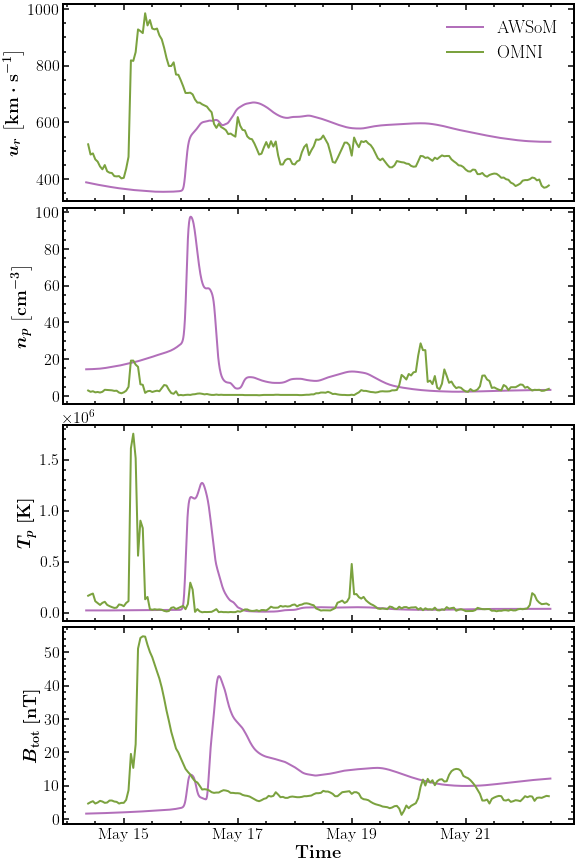

In [45]:
fig, axes = plt.subplots(4,1,figsize=(8,12),constrained_layout=True)
axes[0].plot(sat_df.index,sat_df["ur"],lw=2,label="AWSoM",color="#B26FBA")
axes[0].plot(omni_df.index,omni_df["V_tot"],lw=2,label="OMNI",color="#7BA23F")
axes[1].plot(sat_df.index,sat_df["n"],lw=2,color="#B26FBA")
axes[1].plot(omni_df.index,omni_df["Rho"],lw=2,color="#7BA23F")
axes[2].plot(sat_df.index,sat_df["ti"],lw=2,color="#B26FBA")
axes[2].plot(omni_df.index,omni_df["Temperature"],lw=2,color="#7BA23F")
axes[3].plot(sat_df.index,sat_df["bt"]*1e5,lw=2,color="#B26FBA")
axes[3].plot(omni_df.index,omni_df["B_tot"],lw=2,color="#7BA23F")
date_fmt = DateFormatter("%b\ %d")

for ax_ in axes[0:3]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(5))

axes[0].set_ylabel(r"$\boldsymbol{u_r\ \mathrm{\left[km\cdot s^{-1}\right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{n_p\ \mathrm{\left[cm^{-3}\right]}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{T_p\ \mathrm{\left[K\right]}}$",fontsize=18)
axes[3].set_ylabel(r"$\boldsymbol{B_{\rm tot}\ \mathrm{\left[nT\right]}}$",fontsize=18)

axes[0].legend(loc="upper right",fontsize=18)
axes[3].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-OMNI.pdf",format="pdf")


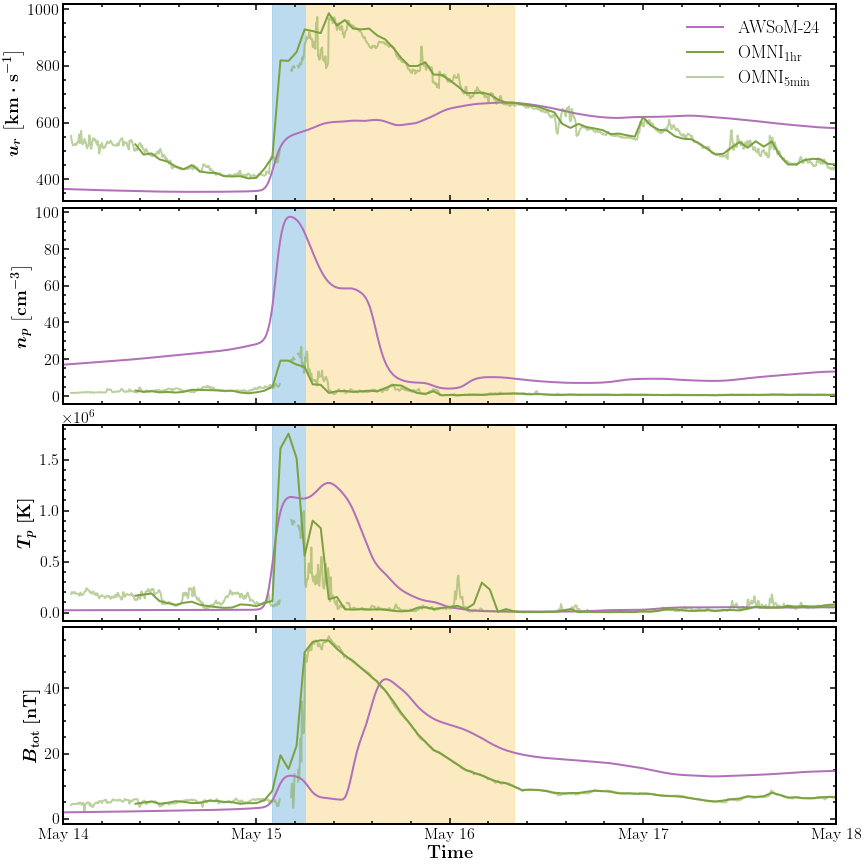

In [48]:
time_shift = datetime.timedelta(hours=24)
time_xlim = (datetime.datetime(2005,5,14),datetime.datetime(2005,5,18))
sheath_duration = (datetime.datetime(2005,5,15,2,0),datetime.datetime(2005,5,15,6,0))
fluxrope_duration = (datetime.datetime(2005,5,15,6,0),datetime.datetime(2005,5,16,8))

fig, axes = plt.subplots(4,1,figsize=(12,12),constrained_layout=True)
axes[0].plot(sat_df.index-time_shift,sat_df["ur"],lw=2,label="AWSoM-24",color="#B26FBA")
axes[0].plot(omni_df.index,omni_df["V_tot"],lw=2,label=r"$\rm OMNI_{1hr}$",color="#7BA23F")
axes[0].plot(omni_5min_df.index,omni_5min_df["vtot"],lw=2,label=r"$\rm OMNI_{5min}$",color="#7BA23F",alpha=0.5)
axes[1].plot(sat_df.index-time_shift,sat_df["n"],lw=2,color="#B26FBA")
axes[1].plot(omni_df.index,omni_df["Rho"],lw=2,color="#7BA23F")
axes[1].plot(omni_5min_df.index,omni_5min_df["n_p"],lw=2,color="#7BA23F",alpha=0.5)
axes[2].plot(sat_df.index-time_shift,sat_df["ti"],lw=2,color="#B26FBA")
axes[2].plot(omni_df.index,omni_df["Temperature"],lw=2,color="#7BA23F")
axes[2].plot(omni_5min_df.index,omni_5min_df["t_p"],lw=2,color="#7BA23F",alpha=0.5)
axes[3].plot(sat_df.index-time_shift,sat_df["bt"]*1e5,lw=2,color="#B26FBA")
axes[3].plot(omni_df.index,omni_df["B_tot"],lw=2,color="#7BA23F")
axes[3].plot(omni_5min_df.index,omni_5min_df["btot"],lw=2,color="#7BA23F",alpha=0.5)


for ax_ in axes[0:3]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)

    

axes[0].set_ylabel(r"$\boldsymbol{u_r\ \mathrm{\left[km\cdot s^{-1}\right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{n_p\ \mathrm{\left[cm^{-3}\right]}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{T_p\ \mathrm{\left[K\right]}}$",fontsize=18)
axes[3].set_ylabel(r"$\boldsymbol{B_{\rm tot}\ \mathrm{\left[nT\right]}}$",fontsize=18)

axes[0].legend(loc="upper right",fontsize=18)
axes[3].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-OMNI-shift.pdf",format="pdf")

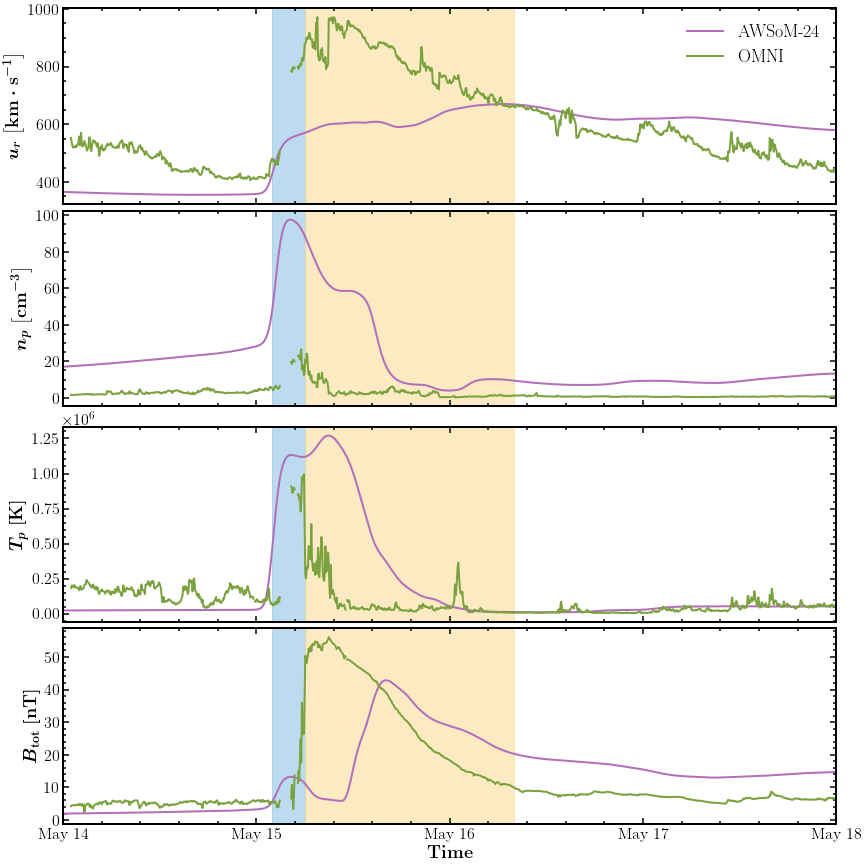

In [47]:

fig, axes = plt.subplots(4,1,figsize=(12,12),constrained_layout=True)
axes[0].plot(sat_df.index-time_shift,sat_df["ur"],lw=2,label="AWSoM-24",color="#B26FBA")
axes[0].plot(omni_5min_df.index,omni_5min_df["vtot"],lw=2,label="OMNI",color="#7BA23F")
axes[1].plot(sat_df.index-time_shift,sat_df["n"],lw=2,color="#B26FBA")
axes[1].plot(omni_5min_df.index,omni_5min_df["n_p"],lw=2,color="#7BA23F")
axes[2].plot(sat_df.index-time_shift,sat_df["ti"],lw=2,color="#B26FBA")
axes[2].plot(omni_5min_df.index,omni_5min_df["t_p"],lw=2,color="#7BA23F")
axes[3].plot(sat_df.index-time_shift,sat_df["bt"]*1e5,lw=2,color="#B26FBA")
axes[3].plot(omni_5min_df.index,omni_5min_df["btot"],lw=2,color="#7BA23F")

for ax_ in axes[0:3]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)

    

axes[0].set_ylabel(r"$\boldsymbol{u_r\ \mathrm{\left[km\cdot s^{-1}\right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{n_p\ \mathrm{\left[cm^{-3}\right]}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{T_p\ \mathrm{\left[K\right]}}$",fontsize=18)
axes[3].set_ylabel(r"$\boldsymbol{B_{\rm tot}\ \mathrm{\left[nT\right]}}$",fontsize=18)

axes[0].legend(loc="upper right",fontsize=18)
axes[3].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-OMNI-5min.pdf",format="pdf")

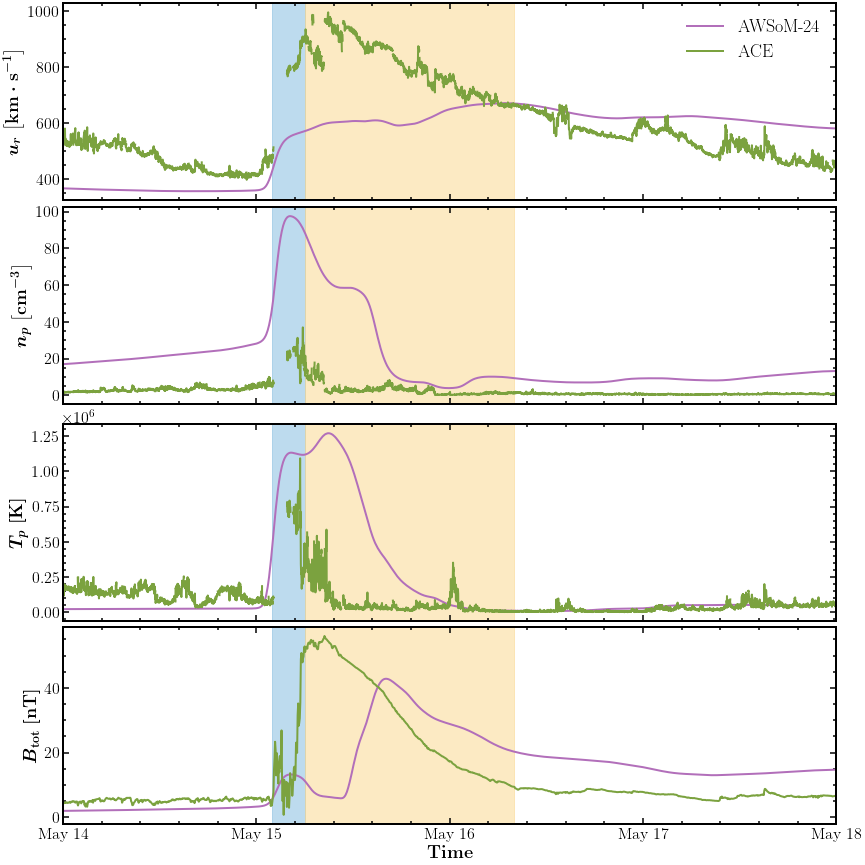

In [49]:
fig, axes = plt.subplots(4,1,figsize=(12,12),constrained_layout=True)
axes[0].plot(sat_df.index-time_shift,sat_df["ur"],lw=2,label="AWSoM-24",color="#B26FBA")
axes[0].plot(ace_plasma_df.index,ace_plasma_df["vtot"],lw=2,label="ACE",color="#7BA23F")
axes[1].plot(sat_df.index-time_shift,sat_df["n"],lw=2,color="#B26FBA")
axes[1].plot(ace_plasma_df.index,ace_plasma_df["n_p"],lw=2,color="#7BA23F")
axes[2].plot(sat_df.index-time_shift,sat_df["ti"],lw=2,color="#B26FBA")
axes[2].plot(ace_plasma_df.index,ace_plasma_df["t_p"],lw=2,color="#7BA23F")
axes[3].plot(sat_df.index-time_shift,sat_df["bt"]*1e5,lw=2,color="#B26FBA")
axes[3].plot(ace_mag_df.index,
np.sqrt(ace_mag_df["bx_gse"]**2 + ace_mag_df["by_gse"]**2 + ace_mag_df["bz_gse"]**2),
lw=2,color="#7BA23F")

for ax_ in axes[0:3]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)

    

axes[0].set_ylabel(r"$\boldsymbol{u_r\ \mathrm{\left[km\cdot s^{-1}\right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{n_p\ \mathrm{\left[cm^{-3}\right]}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{T_p\ \mathrm{\left[K\right]}}$",fontsize=18)
axes[3].set_ylabel(r"$\boldsymbol{B_{\rm tot}\ \mathrm{\left[nT\right]}}$",fontsize=18)

axes[0].legend(loc="upper right",fontsize=18)
axes[3].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-ACE-5min.pdf",format="pdf")

Text(0.5, 0, 'Time')

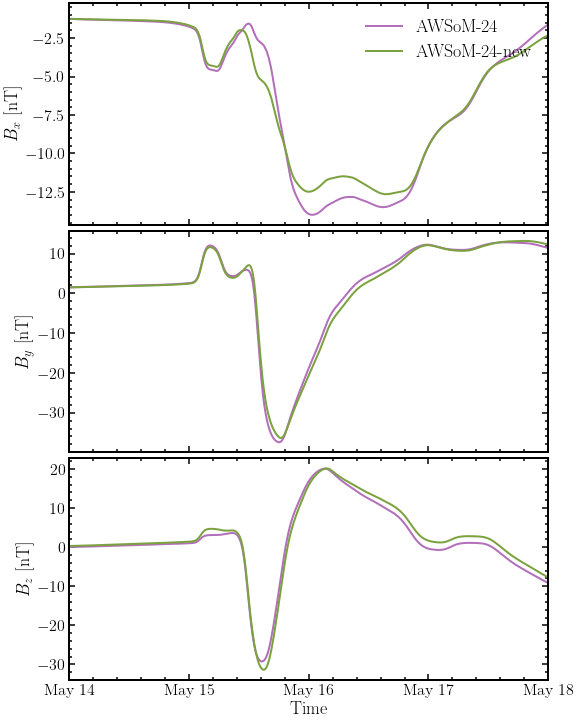

In [26]:
fig, axes = plt.subplots(3,1,figsize=(8,10),constrained_layout=True)
axes[0].plot(sat_df_gse.index - time_shift,sat_df_gse["bx"]*1e5,lw=2,label="AWSoM-24",color="#B26FBA")
axes[1].plot(sat_df_gse.index - time_shift,sat_df_gse["by"]*1e5,lw=2,color="#B26FBA")
axes[2].plot(sat_df_gse.index - time_shift,sat_df_gse["bz"]*1e5,lw=2,color="#B26FBA")
#axes[0].plot(sat_df.index,sat_df["bx"]*1e5,lw=2,label="AWSoM",color="#B26FBA")

axes[0].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["bx"]*1e5,lw=2,label="AWSoM-24-new",color="#7BA23F")
axes[1].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["by"]*1e5,lw=2,color="#7BA23F")
axes[2].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["bz"]*1e5,lw=2,color="#7BA23F")
for ax_ in axes[0:2]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)

axes[0].set_ylabel(r"$B_x\ \mathrm{\left[nT\right]}$",fontsize=18)
axes[1].set_ylabel(r"$B_y\ \mathrm{\left[nT\right]}$",fontsize=18)
axes[2].set_ylabel(r"$B_z\ \mathrm{\left[nT\right]}$",fontsize=18)
axes[0].legend(loc="upper right",fontsize=18)
axes[2].set_xlabel("Time",fontsize=18)

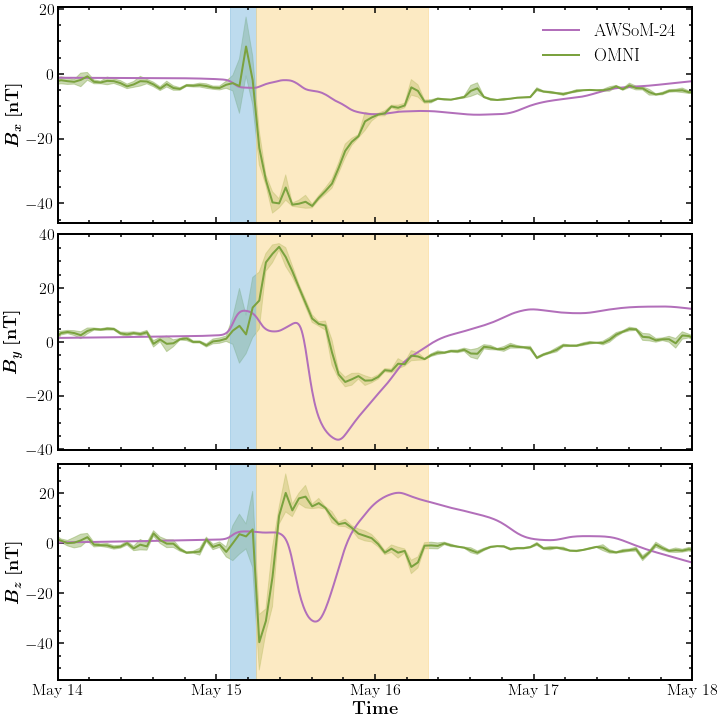

In [50]:
fig, axes = plt.subplots(3,1,figsize=(10,10),constrained_layout=True)
axes[0].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["bx"]*1e5,lw=2,label="AWSoM-24",color="#B26FBA")
axes[1].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["by"]*1e5,lw=2,color="#B26FBA")
axes[2].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["bz"]*1e5,lw=2,color="#B26FBA")
#axes[0].plot(sat_df.index,sat_df["bx"]*1e5,lw=2,label="AWSoM",color="#B26FBA")

axes[0].errorbar(omni_mag_df.index,omni_mag_df["bx"],lw=2,label="OMNI",color="#7BA23F",capsize=2)
axes[0].fill_between(omni_mag_df.index,omni_mag_df["bx"] - omni_mag_df["bx_err"], omni_mag_df["bx"] + omni_mag_df["bx_err"],
color="#7BA23F",alpha=0.4,zorder=0)
axes[1].errorbar(omni_mag_df.index,omni_mag_df["by"],lw=2,label="OMNI",color="#7BA23F",capsize=2)
axes[1].fill_between(omni_mag_df.index,omni_mag_df["by"] - omni_mag_df["by_err"], omni_mag_df["by"] + omni_mag_df["by_err"],
color="#7BA23F",alpha=0.4,zorder=0)
axes[2].errorbar(omni_mag_df.index,omni_mag_df["bz"],lw=2,label="OMNI",color="#7BA23F",capsize=2)
axes[2].fill_between(omni_mag_df.index,omni_mag_df["bz"] - omni_mag_df["bz_err"], omni_mag_df["bz"] + omni_mag_df["bz_err"],
color="#7BA23F",alpha=0.4,zorder=0)
for ax_ in axes[0:2]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)


axes[0].set_ylabel(r"$\boldsymbol{B_x\ \mathrm{\left[nT\right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{B_y\ \mathrm{\left[nT\right]}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{B_z\ \mathrm{\left[nT\right]}}$",fontsize=18)
axes[0].legend(loc="upper right",fontsize=18)
axes[2].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-OMNI-mag.pdf",format="pdf")

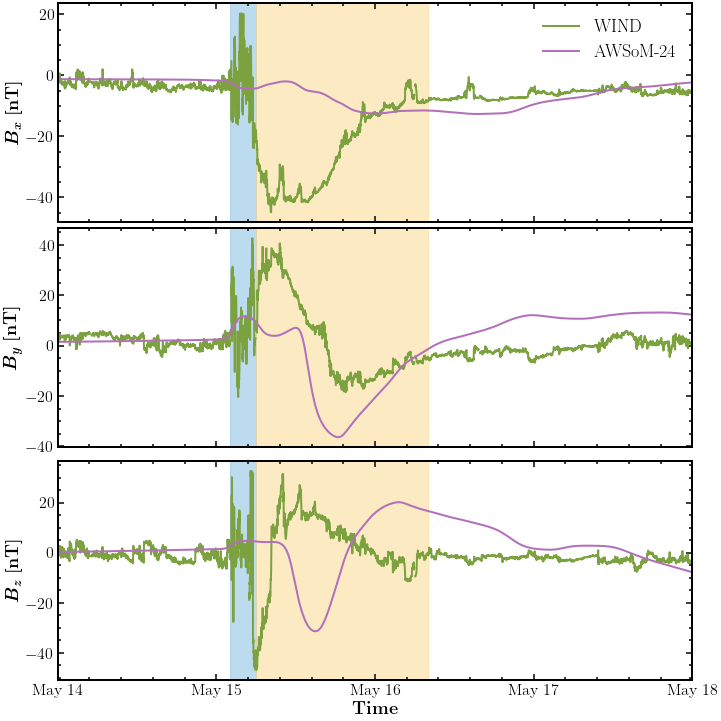

In [51]:
fig, axes = plt.subplots(3,1,figsize=(10,10),constrained_layout=True)
# axes[0].plot(ace_mag_df.index,ace_mag_df["bx_gse"],lw=2,color="#7BA23F",label="ACE")
# axes[1].plot(ace_mag_df.index,ace_mag_df["by_gse"],lw=2,color="#7BA23F")
# axes[2].plot(ace_mag_df.index,ace_mag_df["bz_gse"],lw=2,color="#7BA23F")

axes[0].plot(wind_mag_df.index,wind_mag_df["bx_gse"],lw=2,color="#7BA23F",label="WIND")
axes[1].plot(wind_mag_df.index,wind_mag_df["by_gse"],lw=2,color="#7BA23F")
axes[2].plot(wind_mag_df.index,wind_mag_df["bz_gse"],lw=2,color="#7BA23F")

axes[0].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["bx"]*1e5,lw=2,label="AWSoM-24",color="#B26FBA")
axes[1].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["by"]*1e5,lw=2,color="#B26FBA")
axes[2].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["bz"]*1e5,lw=2,color="#B26FBA")



for ax_ in axes[0:2]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)

axes[0].set_ylabel(r"$\boldsymbol{B_x\ \mathrm{\left[nT\right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{B_y\ \mathrm{\left[nT\right]}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{B_z\ \mathrm{\left[nT\right]}}$",fontsize=18)
axes[0].legend(loc="upper right",fontsize=18)
axes[2].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-WIND-mag-5min.pdf",format="pdf")

(12917.0, 12921.0)

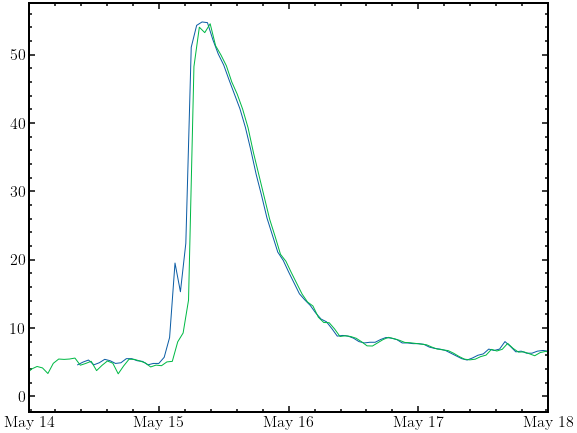

In [29]:
fig, ax = plt.subplots(figsize=(8,6),constrained_layout=True)
ax.plot(omni_df.index,omni_df["B_tot"])
ax.plot(omni_mag_df.index,np.sqrt(omni_mag_df["bx"]**2 + omni_mag_df["by"]**2 + omni_mag_df["bz"]**2))
ax.tick_params(labelsize=16)
ax.tick_params(which="major",length=6,width=1.5)
ax.tick_params(which="minor",length=3,width=1.5)
ax.yaxis.get_offset_text().set_fontsize(16)
ax.xaxis.set_major_formatter(date_fmt)
ax.xaxis.set_major_locator(MaxNLocator(4))
ax.set_xlim(time_xlim)

Text(0.5, 0, '\\textbf{Time}')

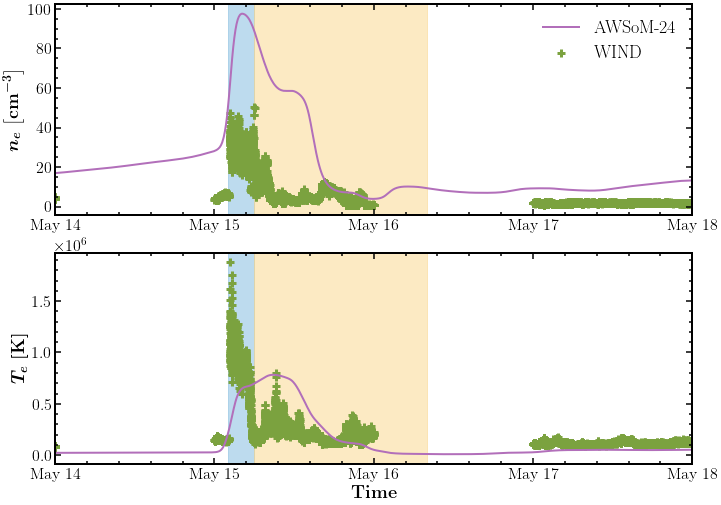

In [30]:
fig, axes = plt.subplots(2,1,figsize=(10,7),constrained_layout=True)

axes[0].scatter(wind_electron_df.index,wind_electron_df["ne_core"],s=50,color="#7BA23F",label="WIND",marker="+",lw=3)
axes[0].plot(sat_df.index - time_shift,sat_df["n"],lw=2,color="#B26FBA",label="AWSoM-24")
axes[1].scatter(wind_electron_df.index,wind_electron_df["te_core"],s=50,color="#7BA23F",label="WIND",marker="+",lw=3)
axes[1].plot(sat_df.index - time_shift,sat_df["te"],lw=2,color="#B26FBA",label="AWSoM-24")

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)


axes[0].set_ylabel(r"$\boldsymbol{n_e\ \mathrm{\left[cm^{-3} \right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{T_e\ \mathrm{\left[K \right]}}$",fontsize=18)
axes[0].legend(loc="upper right",fontsize=18)
axes[1].set_xlabel(r"\textbf{Time}",fontsize=18)

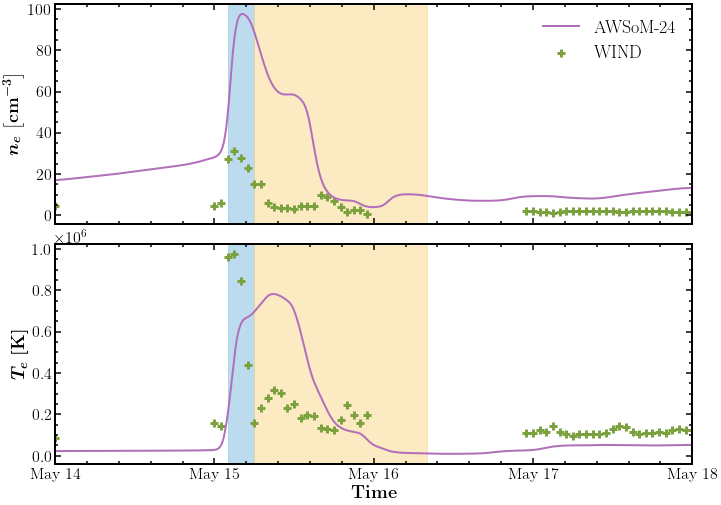

In [52]:
fig, axes = plt.subplots(2,1,figsize=(10,7),constrained_layout=True)

axes[0].scatter(wind_electron_df_res.index,wind_electron_df_res["ne_core"],s=50,color="#7BA23F",label="WIND",marker="+",lw=3)
axes[0].plot(sat_df.index - time_shift,sat_df["n"],lw=2,color="#B26FBA",label="AWSoM-24")
axes[1].scatter(wind_electron_df_res.index,wind_electron_df_res["te_core"],s=50,color="#7BA23F",label="WIND",marker="+",lw=3)
axes[1].plot(sat_df.index - time_shift,sat_df["te"],lw=2,color="#B26FBA",label="AWSoM-24")
axes[0].tick_params(labelbottom=False)
for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)


axes[0].set_ylabel(r"$\boldsymbol{n_e\ \mathrm{\left[cm^{-3} \right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{T_e\ \mathrm{\left[K \right]}}$",fontsize=18)
axes[0].legend(loc="upper right",fontsize=18)
axes[1].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-Wind-Te.pdf",format="pdf")

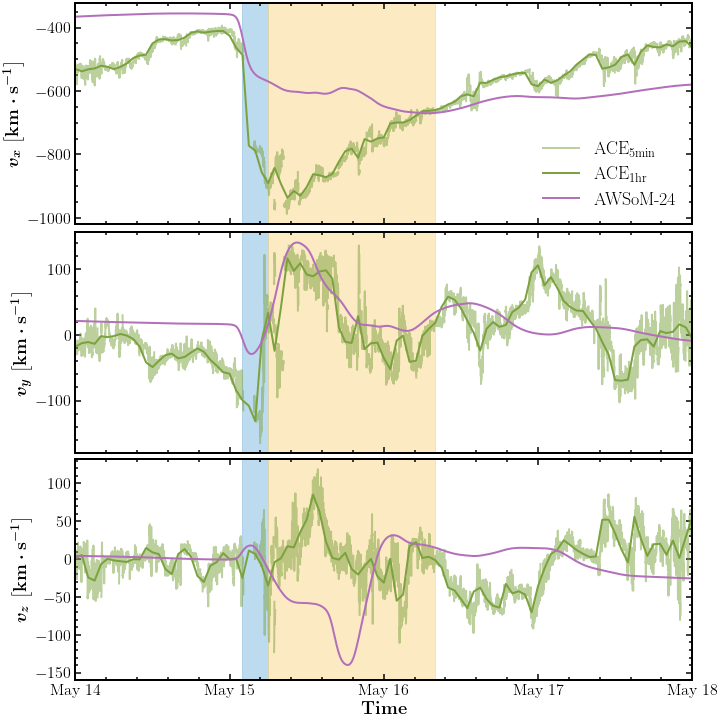

In [53]:
fig, axes = plt.subplots(3,1,figsize=(10,10),constrained_layout=True)
axes[0].plot(ace_plasma_df.index,ace_plasma_df["vx"],lw=2,label=r"$\rm ACE_{5min}$",color="#7BA23F",alpha=0.5)
axes[0].plot(ace_plasma_1H_df.index,ace_plasma_1H_df["vx"],lw=2,label=r"$\rm ACE_{1hr}$",color="#7BA23F")
axes[0].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["ux"],lw=2,label="AWSoM-24",color="#B26FBA")
axes[1].plot(ace_plasma_df.index,ace_plasma_df["vy"],lw=2,label="ACE",color="#7BA23F",alpha=0.5)
axes[1].plot(ace_plasma_1H_df.index,ace_plasma_1H_df["vy"],lw=2,label="ACE",color="#7BA23F")
axes[1].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["uy"],lw=2,label="AWSoM-24",color="#B26FBA")
axes[2].plot(ace_plasma_df.index,ace_plasma_df["vz"],lw=2,label="ACE",color="#7BA23F",alpha=0.5)
axes[2].plot(ace_plasma_1H_df.index,ace_plasma_1H_df["vz"],lw=2,label="ACE",color="#7BA23F")
axes[2].plot(sat_df_gse_new.index - time_shift,sat_df_gse_new["uz"],lw=2,label="AWSoM-24",color="#B26FBA")

#axes[0].plot(sat_df.index,sat_df["bx"]*1e5,lw=2,label="AWSoM",color="#B26FBA")

for ax_ in axes[0:2]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)


axes[0].set_ylabel(r"$\boldsymbol{v_x\ \mathrm{\left[km \cdot s^{-1} \right]}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{v_y\ \mathrm{\left[km \cdot s^{-1} \right]}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{v_z\ \mathrm{\left[km \cdot s^{-1} \right]}}$",fontsize=18)
axes[0].legend(loc="lower right",fontsize=18)
axes[2].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/AWSoM-ACE-Vxyz.pdf",format="pdf")

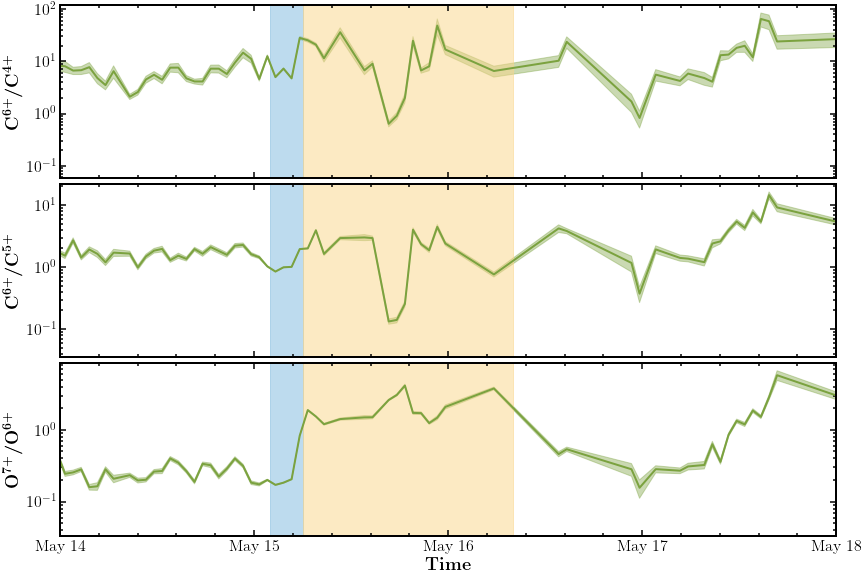

In [55]:
fig, axes = plt.subplots(3,1,figsize=(12,8),constrained_layout=True)

axes[0].errorbar(ace_comp_df.index,ace_comp_df["c6_c4"],lw=2,color="#7BA23F")
axes[0].fill_between(ace_comp_df.index,ace_comp_df["c6_c4"] - ace_comp_df["c6_c4_err"], ace_comp_df["c6_c4"] + ace_comp_df["c6_c4_err"],
color="#7BA23F",alpha=0.4,zorder=0)
axes[1].errorbar(ace_comp_df.index,ace_comp_df["c6_c5"],lw=2,color="#7BA23F")
axes[1].fill_between(ace_comp_df.index,ace_comp_df["c6_c5"] - ace_comp_df["c6_c5_err"], ace_comp_df["c6_c5"] + ace_comp_df["c6_c5_err"],
color="#7BA23F",alpha=0.4,zorder=0)
axes[2].errorbar(ace_comp_df.index,ace_comp_df["o7_o6"],lw=2,color="#7BA23F")
axes[2].fill_between(ace_comp_df.index,ace_comp_df["o7_o6"] - ace_comp_df["o7_o6_err"], ace_comp_df["o7_o6"] + ace_comp_df["o7_o6_err"],
color="#7BA23F",alpha=0.4,zorder=0)

#axes[3].errorbar(ace_comp_df.index,ace_comp_df["c6_c4"]/ace_comp_df["c6_c5"],lw=2,color="#7BA23F")
#axes[1].fill_between(ace_comp_df.index,ace_comp_df["c6_c5"] - ace_comp_df["c6_c5_err"], ace_comp_df["c6_c5"] + ace_comp_df["c6_c5_err"],
#color="#7BA23F",alpha=0.4,zorder=0)

for ax_ in axes[0:2]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
    ax_.set_yscale("log")
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)


axes[0].set_ylabel(r"$\boldsymbol{\mathrm{C^{6+}/C^{4+}}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{\mathrm{C^{6+}/C^{5+}}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{\mathrm{O^{7+}/O^{6+}}}$",fontsize=18)
#axes[3].set_ylabel(r"$\boldsymbol{\mathrm{C^{5+}/C^{4+}}}$",fontsize=18)
axes[2].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/ACE-SWICS-charge-ratio.pdf",format="pdf")

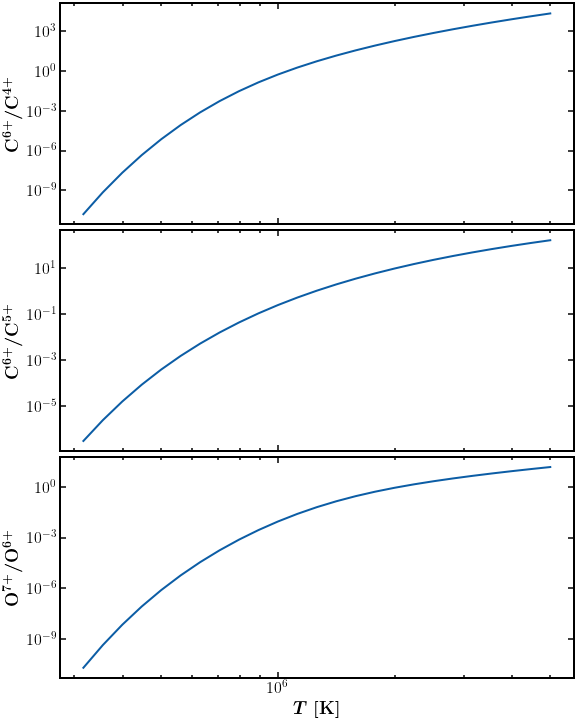

In [56]:
carbon_charge_stat = ch.ioneq("c")
carbon_charge_stat.load()
c4_fraction = carbon_charge_stat.Ioneq[4,30:55]
c5_fraction = carbon_charge_stat.Ioneq[5,30:55]
c6_fraction = carbon_charge_stat.Ioneq[6,30:55]
carbon_temp = carbon_charge_stat.Temperature[30:55]

oxygen_charge_stat = ch.ioneq("o")
oxygen_charge_stat.load()
o7_fraction = oxygen_charge_stat.Ioneq[7,30:55]
o6_fraction = oxygen_charge_stat.Ioneq[6,30:55]
oxygen_temp = oxygen_charge_stat.Temperature[30:55]

func_c6_c4 = interpolate.interp1d(c6_fraction/c4_fraction,carbon_temp)
func_c6_c5 = interpolate.interp1d(c6_fraction/c5_fraction,carbon_temp)
func_o7_o6 = interpolate.interp1d(o7_fraction/o6_fraction,oxygen_temp)

fig, axes = plt.subplots(3,1,figsize=(8,10),constrained_layout=True)

axes[0].plot(carbon_temp,c6_fraction/c4_fraction,lw=2)
axes[1].plot(carbon_temp,c6_fraction/c5_fraction,lw=2)
axes[2].plot(oxygen_temp,o7_fraction/o6_fraction,lw=2)

for ax_ in axes[0:2]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.set_xscale("log")
    ax_.set_yscale("log")
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    #ax_.xaxis.set_major_locator(MaxNLocator(5))

axes[0].set_ylabel(r"$\boldsymbol{\mathrm{C^{6+}/C^{4+}}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{\mathrm{C^{6+}/C^{5+}}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{\mathrm{O^{7+}/O^{6+}}}$",fontsize=18)
axes[2].set_xlabel(r"$\boldsymbol{T\ [\rm K]}$",fontsize=18)
plt.savefig(fname="../figs/L1/CHIANTI-ratio.pdf",format="pdf")

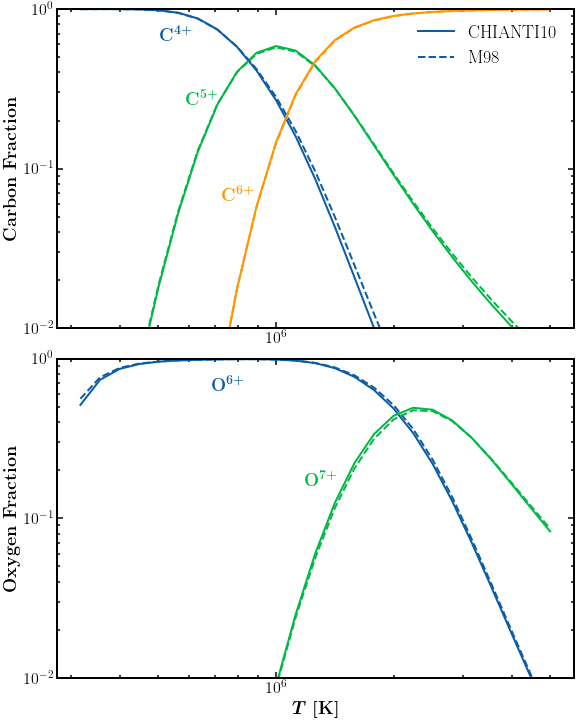

In [57]:
fig, axes = plt.subplots(2,1,figsize=(8,10),constrained_layout=True)

axes[0].plot(carbon_temp,c4_fraction,lw=2,label="CHIANTI10")
axes[0].plot(carbon_temp,c5_fraction,lw=2)
axes[0].plot(carbon_temp,c6_fraction,lw=2)

axes[0].plot(m1998_df["temp"],m1998_df["c4"],lw=2,color="#0C5DA5",ls="--",label=" M98")
axes[0].plot(m1998_df["temp"],m1998_df["c5"],lw=2,color="#00B945",ls="--")
axes[0].plot(m1998_df["temp"],m1998_df["c6"],lw=2,color="#FF9500",ls="--")

axes[1].plot(oxygen_temp,o6_fraction,lw=2)
axes[1].plot(oxygen_temp,o7_fraction,lw=2)

axes[1].plot(m1998_df["temp"],m1998_df["o6"],lw=2,color="#0C5DA5",ls="--")
axes[1].plot(m1998_df["temp"],m1998_df["o7"],lw=2,color="#00B945",ls="--")

for ax_ in axes:
    ax_.set_xscale("log")
    ax_.set_yscale("log")
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.set_ylim(0.01,1)
    #ax_.xaxis.set_major_locator(MaxNLocator(5))

leg0 = axes[0].legend(loc="upper right",fontsize=18)
axes[0].text(0.2,0.9,r"$\boldsymbol{\rm C^{4+}}$",transform=axes[0].transAxes,color = "#0C5DA5",fontsize=18)
axes[0].text(0.25,0.7,r"$\boldsymbol{\rm C^{5+}}$",transform=axes[0].transAxes,color = "#00B945",fontsize=18)
axes[0].text(0.32,0.4,r"$\boldsymbol{\rm C^{6+}}$",transform=axes[0].transAxes,color = "#FF9500",fontsize=18)
axes[1].text(0.3,0.9,r"$\boldsymbol{\rm O^{6+}}$",transform=axes[1].transAxes,color = "#0C5DA5",fontsize=18)
axes[1].text(0.48,0.6,r"$\boldsymbol{\rm O^{7+}}$",transform=axes[1].transAxes,color = "#00B945",fontsize=18)
axes[0].set_ylabel(r"\textbf{Carbon Fraction}",fontsize=18)
axes[1].set_ylabel(r"\textbf{Oxygen Fraction}",fontsize=18)

axes[1].set_xlabel(r"$\boldsymbol{T\ \mathrm{[K]}}$",fontsize=18)
plt.savefig(fname="../figs/L1/CHIANTI-M98.pdf",format="pdf")

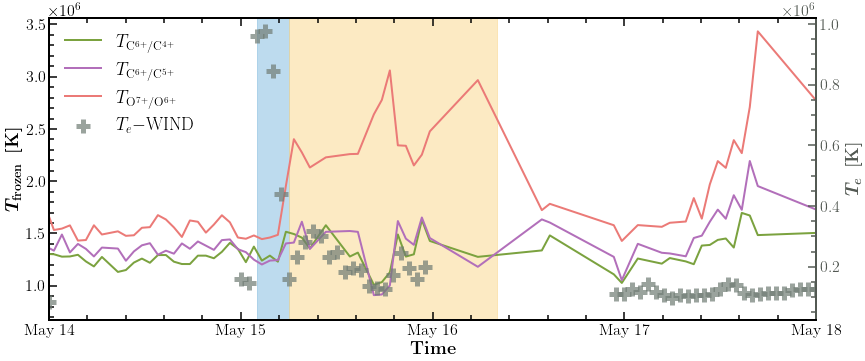

In [58]:
fig, ax = plt.subplots(figsize=(12,5),constrained_layout=True)
ln1, = ax.plot(ace_comp_df.index,func_c6_c4(ace_comp_df["c6_c4"]),lw=2,color="#7BA23F",
label=r"$T_{\mathrm{C^{6+}/C^{4+}}}$")
ln2, = ax.plot(ace_comp_df.index,func_c6_c5(ace_comp_df["c6_c5"]),lw=2,color="#B26FBA",
label=r"$T_{\mathrm{C^{6+}/C^{5+}}}$",ls="-")
ln3, = ax.plot(ace_comp_df.index,func_o7_o6(ace_comp_df["o7_o6"]),lw=2,color="#EB7A77",
label=r"$T_{\mathrm{O^{7+}/O^{6+}}}$",ls="-")
ax_wind = ax.twinx()
ln4 = ax_wind.scatter(wind_electron_df_res.index,wind_electron_df_res["te_core"],s=200,color="#707C74",label=r"$T_e-$WIND",marker="+",lw=5,alpha=0.7)
leg = [ln1,ln2,ln3,ln4]

for ax_ in (ax,ax_wind):
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=8,width=1.5)
    ax_.tick_params(which="minor",length=5,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.set_xlim(time_xlim)
ax.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
ax.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)


ax_wind.spines['right'].set_color('#535953')
ax_wind.tick_params(axis='y', colors='#535953',which="both")

ax.legend(leg,[leg_.get_label() for leg_ in leg],loc = 'upper left',fontsize = 18,frameon=False)
ax.set_ylabel(r"$\boldsymbol{T_{\rm frozen}\ \left[\mathrm{K}\right]}$",fontsize=18)
ax_wind.set_ylabel(r"$\boldsymbol{T_{e}\ \left[\mathrm{K}\right]}$",fontsize=18,color="#535953")
ax.set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/ACE-Tfr-WIND-Te.pdf",format="pdf")


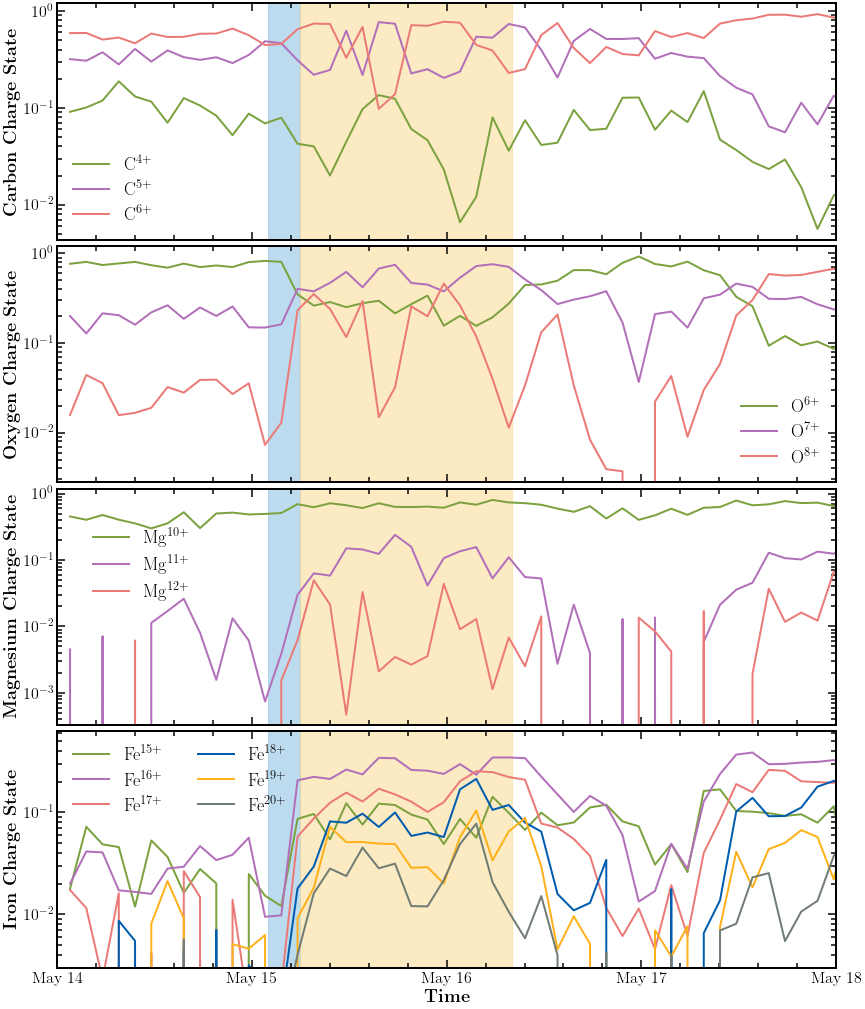

In [62]:
fig, axes = plt.subplots(4,1,figsize=(12,14),constrained_layout=True)

axes[0].plot(ace_comp_all_df.index,ace_comp_all_df["c4"],lw=2,color="#7BA23F",
label=r"$\rm C^{4+}$")
axes[0].plot(ace_comp_all_df.index,ace_comp_all_df["c5"],lw=2,color="#B26FBA",
label=r"$\rm C^{5+}$")
axes[0].plot(ace_comp_all_df.index,ace_comp_all_df["c6"],lw=2,color="#EB7A77",
label=r"$\rm C^{6+}$")

axes[1].plot(ace_comp_all_df.index,ace_comp_all_df["o6"],lw=2,color="#7BA23F",
label=r"$\rm O^{6+}$")
axes[1].plot(ace_comp_all_df.index,ace_comp_all_df["o7"],lw=2,color="#B26FBA",
label=r"$\rm O^{7+}$")
axes[1].plot(ace_comp_all_df.index,ace_comp_all_df["o8"],lw=2,color="#EB7A77",
label=r"$\rm O^{8+}$")

axes[2].plot(ace_comp_all_df.index,ace_comp_all_df["mg10"],lw=2,color="#7BA23F",
label=r"$\rm Mg^{10+}$")
axes[2].plot(ace_comp_all_df.index,ace_comp_all_df["mg11"],lw=2,color="#B26FBA",
label=r"$\rm Mg^{11+}$")
axes[2].plot(ace_comp_all_df.index,ace_comp_all_df["mg12"],lw=2,color="#EB7A77",
label=r"$\rm Mg^{12+}$")

axes[3].plot(ace_comp_all_df.index,ace_comp_all_df["fe15"],lw=2,label=r"$\mathrm{Fe^{15+}}$",
color="#7BA23F")
axes[3].plot(ace_comp_all_df.index,ace_comp_all_df["fe16"],lw=2,label=r"$\mathrm{Fe^{16+}}$",
color="#B26FBA")
axes[3].plot(ace_comp_all_df.index,ace_comp_all_df["fe17"],lw=2,label=r"$\mathrm{Fe^{17+}}$",
color="#EB7A77")
axes[3].plot(ace_comp_all_df.index,ace_comp_all_df["fe18"],lw=2,label=r"$\mathrm{Fe^{18+}}$",
color="#005CAF")
axes[3].plot(ace_comp_all_df.index,ace_comp_all_df["fe19"],lw=2,label=r"$\mathrm{Fe^{19+}}$",
color="#FFB11B")
axes[3].plot(ace_comp_all_df.index,ace_comp_all_df["fe20"],lw=2,label=r"$\mathrm{Fe^{20+}}$",
color="#707C74")

for ax_ in axes[0:3]:
    ax_.tick_params(labelbottom=False)
for ax_ in axes:
    ax_.set_yscale("log")
    ax_.set_xlim(time_xlim)
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=8,width=1.5)
    ax_.tick_params(which="minor",length=5,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)


axes[0].legend(loc="lower left",fontsize=18)
axes[1].legend(loc="lower right",fontsize=18)
axes[2].legend(bbox_to_anchor=(0.04,0.6,0.15,0.3),fontsize=18)
axes[3].legend(loc="upper left",fontsize=18,ncol=2)

axes[3].set_ylim(bottom=3e-3)

axes[0].set_ylabel(r"\textbf{Carbon Charge State}",fontsize=18)
axes[1].set_ylabel(r"\textbf{Oxygen Charge State}",fontsize=18)
axes[2].set_ylabel(r"\textbf{Magnesium Charge State}",fontsize=18)
axes[3].set_ylabel(r"\textbf{Iron Charge State}",fontsize=18)
axes[3].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/ACE-SWICS-charge-dist.pdf",format="pdf")

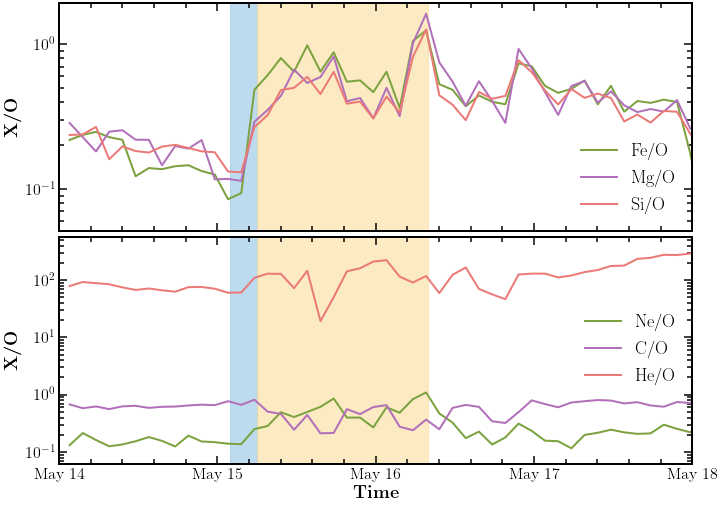

In [60]:
fig, axes = plt.subplots(2,1,figsize=(10,7),constrained_layout=True)

axes[0].plot(ace_abund_df.index,ace_abund_df["Fe/O"],lw=2,color="#7BA23F",label=r"Fe/O")
axes[0].plot(ace_abund_df.index,ace_abund_df["Mg/O"],lw=2,color="#B26FBA",label=r"Mg/O")
axes[0].plot(ace_abund_df.index,ace_abund_df["Si/O"],lw=2,color="#EB7A77",label=r"Si/O")

axes[1].plot(ace_abund_df.index,ace_abund_df["Ne/O"],lw=2,color="#7BA23F",label=r"Ne/O")
axes[1].plot(ace_abund_df.index,ace_abund_df["C/O"],lw=2,color="#B26FBA",label=r"C/O")
axes[1].plot(ace_abund_df.index,ace_abund_df["He/O"],lw=2,color="#EB7A77",label=r"He/O")

for ax_ in axes[0:1]:
    ax_.tick_params(labelbottom=False)
for ax_ in axes:
    ax_.set_yscale("log")
    ax_.set_xlim(time_xlim)
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=8,width=1.5)
    ax_.tick_params(which="minor",length=5,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)
    ax_.set_ylabel(r"$\boldsymbol{\mathrm{X/O}}$",fontsize=18)

axes[0].legend(loc="lower right",fontsize=18)
axes[1].legend(loc="center right",fontsize=18)
axes[1].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/ACE-SWICS-abund.pdf",format="pdf")


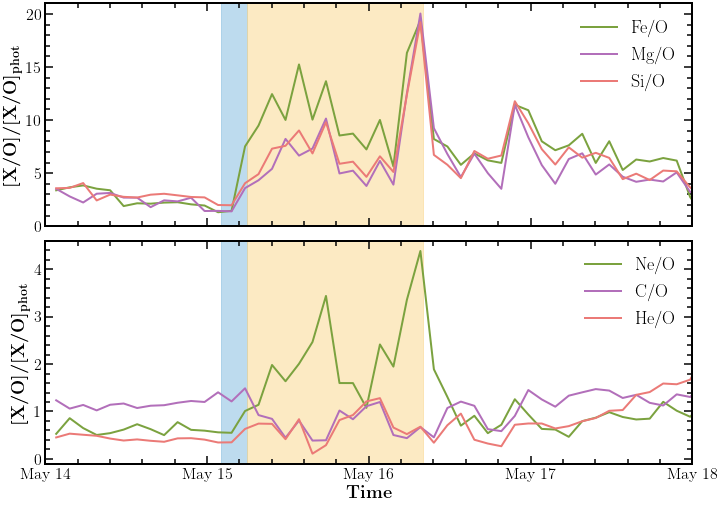

In [61]:
photo_abund = {"C":8.43,"O":8.69,"He":10.93,"Fe":7.50,"Mg":7.60,"Si":7.51}
Ne_O_photo = 0.25

C_O_photo = 10**(photo_abund["C"] - photo_abund["O"])
He_O_photo = 10**(photo_abund["He"] - photo_abund["O"])
Fe_O_photo = 10**(photo_abund["Fe"] - photo_abund["O"])
Mg_O_photo = 10**(photo_abund["Mg"] - photo_abund["O"])
Si_O_photo = 10**(photo_abund["Si"] - photo_abund["O"])

fig, axes = plt.subplots(2,1,figsize=(10,7),constrained_layout=True)

axes[0].plot(ace_abund_df.index,ace_abund_df["Fe/O"]/Fe_O_photo,lw=2,color="#7BA23F",label=r"Fe/O")
axes[0].plot(ace_abund_df.index,ace_abund_df["Mg/O"]/Mg_O_photo,lw=2,color="#B26FBA",label=r"Mg/O")
axes[0].plot(ace_abund_df.index,ace_abund_df["Si/O"]/Si_O_photo,lw=2,color="#EB7A77",label=r"Si/O")

axes[1].plot(ace_abund_df.index,ace_abund_df["Ne/O"]/Ne_O_photo,lw=2,color="#7BA23F",label=r"Ne/O")
axes[1].plot(ace_abund_df.index,ace_abund_df["C/O"]/C_O_photo,lw=2,color="#B26FBA",label=r"C/O")
axes[1].plot(ace_abund_df.index,ace_abund_df["He/O"]/He_O_photo,lw=2,color="#EB7A77",label=r"He/O")

for ax_ in axes[0:1]:
    ax_.tick_params(labelbottom=False)
for ax_ in axes:
    #ax_.set_yscale("log")
    ax_.set_xlim(time_xlim)
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=8,width=1.5)
    ax_.tick_params(which="minor",length=5,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(4))
    ax_.axvspan(sheath_duration[0],sheath_duration[1],color="#7DB9DE",alpha=0.5,zorder=0)
    ax_.axvspan(fluxrope_duration[0],fluxrope_duration[1],color="#FAD689",alpha=0.5,zorder=0)
    ax_.set_ylabel(r"$\boldsymbol{[\mathrm{X/O}]/\mathrm{[X/O]_{phot}}}$",fontsize=18)

axes[0].legend(loc="upper right",fontsize=18)
axes[1].legend(loc="upper right",fontsize=18)
axes[1].set_xlabel(r"\textbf{Time}",fontsize=18)
plt.savefig(fname="../figs/L1/ACE-SWICS-abund-tophot.pdf",format="pdf")


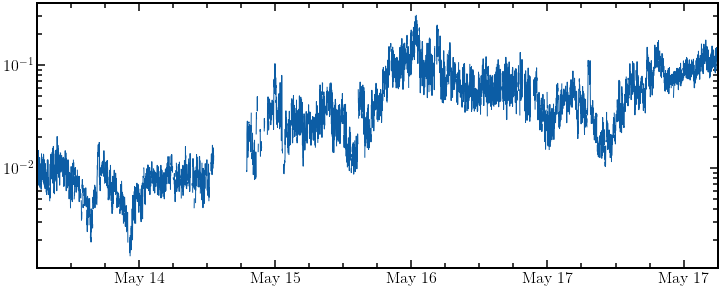

In [42]:
fig, ax = plt.subplots(figsize=(10,4),constrained_layout=True)
ax.plot(ace_plasma_df.index,ace_plasma_df["He/H"])
for ax_ in [ax]:
    ax_.set_yscale("log")
    ax_.set_xlim(time_xlim)
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=8,width=1.5)
    ax_.tick_params(which="minor",length=5,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(5))

Text(0.5, 0, '\\textbf{Time}')

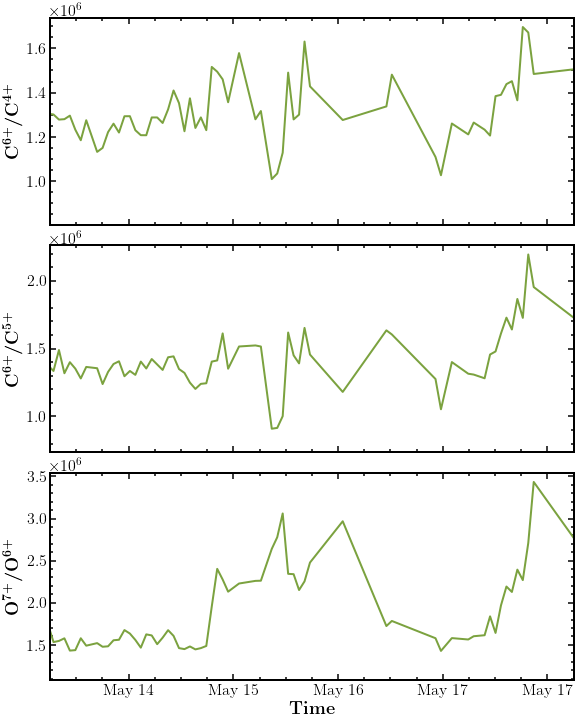

In [43]:
fig, axes = plt.subplots(3,1,figsize=(8,10),constrained_layout=True)

axes[0].errorbar(ace_comp_df.index,func_c6_c4(ace_comp_df["c6_c4"]),lw=2,color="#7BA23F")
axes[1].errorbar(ace_comp_df.index,func_c6_c5(ace_comp_df["c6_c5"]),lw=2,color="#7BA23F")
axes[2].errorbar(ace_comp_df.index,func_o7_o6(ace_comp_df["o7_o6"]),lw=2,color="#7BA23F")


for ax_ in axes[0:2]:
    ax_.tick_params(labelbottom=False)

for ax_ in axes:
    ax_.tick_params(labelsize=16)
    ax_.tick_params(which="major",length=6,width=1.5)
    ax_.tick_params(which="minor",length=3,width=1.5)
    ax_.yaxis.get_offset_text().set_fontsize(16)
    ax_.xaxis.set_major_formatter(date_fmt)
    ax_.xaxis.set_major_locator(MaxNLocator(5))
    ax_.set_xlim(time_xlim)

axes[0].set_ylabel(r"$\boldsymbol{\mathrm{C^{6+}/C^{4+}}}$",fontsize=18)
axes[1].set_ylabel(r"$\boldsymbol{\mathrm{C^{6+}/C^{5+}}}$",fontsize=18)
axes[2].set_ylabel(r"$\boldsymbol{\mathrm{O^{7+}/O^{6+}}}$",fontsize=18)
axes[2].set_xlabel(r"\textbf{Time}",fontsize=18)

